In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stops=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/train - train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test - test.csv')

In [ ]:
train_data.head()

,text,aspect,label
0,can you check whether its cancelled completely?,cancelled,1
1,cannot rely on both milk delivery and grocery ...,Milk,0
2,"I get no notification, however the app is real...",notification,0
3,"Love this app, but would love it even more if ...",view,1
4,it does not let me load a clip on the scene,load,0


In [ ]:
#positive : 1,  negative : 0, neutral: 2


neutral_ind = train_data.loc[train_data.label==2].index

train_data = train_data.drop(neutral_ind, axis = 0)


In [ ]:
set(train_data.label)

{0, 1}

In [ ]:
test_data.head()

,text,aspect
0,improve your customer service and product avai...,Customer service
1,"functionality is great, almost as in desktop v...",mobile version
2,but it keeps starting from zoomed in and then ...,zoomed
3,hey marilyn thanks for your answer the soc2 ty...,Security
4,@delanovc @zoom @airtable @notionhq @calendly ...,apple


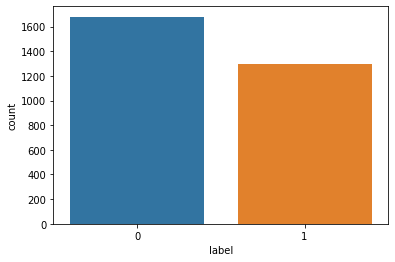

In [ ]:
sns.countplot(x = train_data.label, data = train_data)

In [ ]:
"removing stopwords"
new_texts=[]
for text in train_data.text.tolist():
  char=[]
  for i in text.split():
    if i in stops:
      pass
    else:
      char.append(i)
  new_texts.append(' '. join(char))
  
train_data['new_texts']=new_texts 

In [ ]:
train_data.head(10)

,text,aspect,label,new_texts
0,can you check whether its cancelled completely?,cancelled,1,check whether cancelled completely?
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery items.
2,"I get no notification, however the app is real...",notification,0,"I get notification, however app really fine"
3,"Love this app, but would love it even more if ...",view,1,"Love app, would love even Gantt charts Calenda..."
4,it does not let me load a clip on the scene,load,0,let load clip scene
6,unlimited yearly at $216/year,yearly,1,unlimited yearly $216/year
7,"some times missing to deliver, some times diff...","deliver,",0,"times missing deliver, times different orders ..."
8,Would love the ability to “un-delete” deleted ...,tasks,1,Would love ability “un-delete” deleted tasks a...
10,so i wanted to download the app.,app,0,wanted download app.
11,-&gt; i want to learn for the future whether w...,learn,1,-&gt; want learn future whether team something...


In [ ]:
train_texts = train_data.text.values.tolist()
train_labels = train_data.label.values.tolist()
test_texts = test_data.text.values.tolist()


In [ ]:
train_texts[:4]

['can you check whether its cancelled completely?',
 'cannot rely on both milk delivery and grocery items.',
 'I get no notification, however the app is really fine',
 'Love this app, but would love it even more if Gantt charts and Calendar view were available on iPhone!']

In [ ]:
test_texts[:4]

['improve your customer service and product availability',
 'functionality is great, almost as in desktop version, but mobile version needs a lot of improvement esp the speed',
 'but it keeps starting from zoomed in and then slowly zooming out as the music plays.',
 'hey marilyn thanks for your answer the soc2 type 1 certification is a document that can be shared with external parties for security assessment do you have a copy of the report we could explore?']

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size = 0.2, random_state = 42, 
    stratify = train_labels
)


Steps involve in Fine Tuning Custom models


1. Prepare dataset
2. Load pretrained tokenizer, call it with dataset
3. Build Pytorch datasets with encodings
4. Load pretrained Model
5. Load Trainer and train it (OR) use native Pytorch training Pipeline


In [ ]:
!pip install transformers
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast,DistilBertForSequenceClassification
from transformers import Trainer,TrainingArguments

     |████████████████████████████████| 3.4 MB 4.1 MB/s 
     |████████████████████████████████| 596 kB 38.0 MB/s 
     |████████████████████████████████| 895 kB 43.8 MB/s 
     |████████████████████████████████| 3.3 MB 37.4 MB/s 
     |████████████████████████████████| 61 kB 477 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
model_name = 'distilbert-base-uncased'

#tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',
                                                    num_labels=2)
train_encodings = tokenizer(train_texts, truncation=True, padding=True,return_tensors = 'pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True,return_tensors = 'pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True,return_tensors = 'pt')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


## Test Dataset
class SentimentTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    def __len__(self):
        return len(self.encodings)

In [ ]:
train_dataset = SentimentDataset(train_encodings, train_labels)

val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentTestDataset(test_encodings)

In [ ]:
#Defining A Simple Metrics Function

from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    #recall = recall_score(y_true=labels, y_pred=pred)
    #precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(labels, pred, average='weighted')

    return {"accuracy": accuracy,"f1_score":f1} 

#Defining Training Arguments

training_args = TrainingArguments(
    output_dir= './res',          # output directory
    evaluation_strategy="steps",
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,
    learning_rate = 4e-5,
    warmup_steps=500, 
    seed = 100,               # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs4',            # directory for storing logs
    #logging_steps=10,
    load_best_model_at_end=True,
)


In [ ]:
#FineTuning with Trainer

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 2)

trainer = Trainer(model = model, args=training_args, train_dataset  = train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics = compute_metrics)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

In [ ]:
model = trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model('/content/drive/MyDrive/ABSA', )

In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = DistilBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/ABSA", local_files_only = True)
trainer = Trainer(model=model)
trainer.model = model.cuda()


loading configuration file /content/drive/MyDrive/ABSA/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.15.0",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/ABSA/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/A